# PAO-EquiML

In [1]:
import logging
import torch
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colormaps
#from torch_cluster import radius_graph
#from torch_geometric.data import Data, DataLoader
from torch_scatter import scatter
from torch.utils.data import Dataset, DataLoader

from e3nn import o3
from e3nn.nn import FullyConnectedNet, Gate, models
from e3nn.o3 import FullyConnectedTensorProduct
from e3nn.math import soft_one_hot_linspace
from e3nn.util.test import assert_equivariant

from pathlib import Path
from pao_file_utils import parse_pao_file, append_samples, write_pao_file, read_cp2k_energy

t = torch.tensor

In [7]:
change_of_coord = t([
    # this specifies the change of basis yzx -> xyz
    [0., 0., 1.],
    [1., 0., 0.],
    [0., 1., 0.]
])
prim_basis_specs = {
    "O": "2x0e + 2x1o + 1x2e", # DZVP-MOLOPT-GTH for Oxygen: two s-shells, two p-shells, one d-shell
    "H": "2x0e + 1x1o" # DZVP-MOLOPT-GTH for Hydrogen: two s-shells, one p-shell
}
pao_basis_size = 4

In [3]:
class PAO_Object:
    def __init__(self, kind, atomkind, coords, xblock):
        self.kind = kind
        self.atomkind = atomkind
        self.coords = coords
        self.xblock = xblock
        self.label = xblock.T @ torch.inverse(xblock @ xblock.T) @ xblock
        #U, S, Vh = torch.linalg.svd(xblock, full_matrices=False)
        #self.label = Vh

class PAO_dataset(Dataset):
    def __init__(self, pao_objects):
        self.labels = [pao_object.label for pao_object in pao_objects]
        self.atomkinds = [generate_f_in(pao_object) for pao_object in pao_objects]
        self.coords = [pao_object.coords for pao_object in pao_objects]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        coords = self.coords[idx]
        label = self.labels[idx]
        atomkind = self.atomkinds[idx]
        return coords, atomkind, label

In [4]:
def parse_pao_file_torch(path: Path):
    kinds, atom2kind, coords, xblocks = parse_pao_file(path)
    return kinds, atom2kind, t(coords, dtype=torch.float32), [t(x, dtype=torch.float32) for x in xblocks]

# Remove central atom and create PAO object from PAO file
def generate_pao_object_from_file(file_path):
    pao_objects = []
    kinds, atom2kind, coords, xblocks = parse_pao_file_torch(file_path)
    for idx, atom in enumerate(atom2kind):
#        coords = torch.roll(coords, -1, 1)
        rel_coords = coords - coords[idx]
        idxs = list(range(len(atom2kind)))
        idxs.pop(idx)
        pao_objects.append(PAO_Object(kinds[atom], [atom2kind[atom] for atom in idxs], rel_coords[idxs], xblocks[idx]))
    return pao_objects

In [5]:
def generate_irreps_output(pao_basis_size, atom_species):
    prim_basis_specs = {
    "O": "2x0e + 2x1o + 1x2e", # DZVP-MOLOPT-GTH for Oxygen: two s-shells, two p-shells, one d-shell
    "H": "2x0e + 1x1o" # DZVP-MOLOPT-GTH for Hydrogen: two s-shells, one p-shell
    }
    prim_basis_spec = prim_basis_specs[atom_species]
    prim_basis_size = o3.Irreps(prim_basis_spec).dim
    irreps_output = o3.Irreps(" + ".join(pao_basis_size*[prim_basis_spec]))
    return irreps_output

In [8]:
pao_objects = []
#for phi in ["00"]:
#    pao_objects.extend(generate_pao_object_from_file(Path(f"2H2O_rotations/phi_{phi}/2H2O_pao44-1_0.pao")))
pao_objects.extend(generate_pao_object_from_file(Path(f"2H2O_rotations/phi_00/2H2O_pao44-1_0.pao")))
pao_objects_O = [pao_object for pao_object in pao_objects if pao_object.kind.atomic_number==8]
pao_objects_H = [pao_object for pao_object in pao_objects if pao_object.kind.atomic_number==1]
kinds, atom2kind, coords, _ = parse_pao_file_torch(Path("2H2O_rotations/phi_00/2H2O_pao44-1_0.pao"))

# Irreps Input
irreps_input = o3.Irreps("2x0e") # features: is_hydrogen, is_oxygen

# Irreps Spherical Harmonics
irreps_sh = o3.Irreps.spherical_harmonics(lmax=3)

In [9]:
print(len(pao_objects_O))
print(generate_irreps_output(4,"O"))
print(len(pao_objects_H))
print(generate_irreps_output(4,"H"))

2
2x0e+2x1o+1x2e+2x0e+2x1o+1x2e+2x0e+2x1o+1x2e+2x0e+2x1o+1x2e
4
2x0e+1x1o+2x0e+1x1o+2x0e+1x1o+2x0e+1x1o


In [10]:
# Preprocessing, model, and loss functions.
max_radius = 4
num_neighbours=5

def edge_vec(coords):
    assert coords.shape[0] == num_neighbors
    return coords

def normalize(xblock):
    return xblock / torch.norm(xblock, dim=1)[:,None]

def labelfy(xblock):
    # The loss_functions requires orthonormal labels.
    U, S, Vh = torch.linalg.svd(xblock, full_matrices=False)
    return Vh

def generate_f_in(pao_object):  
    f_in = t([(k=="H", k=="O") for k in pao_object.atomkind], dtype=torch.float32)
    return f_in

def regularization(label):
    return 0.1 * (1 - torch.norm(label, dim=1)).pow(2).sum()

def loss_function_1(pred, label):
    loss = torch.sum(torch.sum((pred - label).pow(2), dim=2), dim=1).mean()
    return loss

def loss_function_2(pred, label):
    pred_projector = torch.bmm(torch.transpose(pred, dim0=1, dim1=2), pred)
    label_projector = torch.bmm(torch.transpose(label, dim0=1, dim1=2), label)
    residual = pred_projector - label_projector
#    return residual.pow(2).sum() + regularization(pred)
#    return torch.sum(torch.sum(residual.pow(2), dim=2), dim=1).mean()
#    return torch.sum(torch.sum(residual.pow(2), dim=2), dim=1).mean()
#    return residual.abs().mean()
    return residual.pow(2).mean()

In [22]:
def model_O(edge_vec, f_in):
    sh = o3.spherical_harmonics(irreps_sh, edge_vec, normalize=True, normalization='component')
    emb = soft_one_hot_linspace(edge_vec.norm(dim=2), 0.0, max_radius, num_distances,
                                basis='smooth_finite', cutoff=True).mul(num_distances**0.5)
    flat_xyz = tp_O(f_in, sh, fc_O(emb)).sum(dim=1).div(num_neighbours**0.5)
    flat_yzx = torch.matmul(flat_xyz, D_O)
    return flat_yzx.reshape(batch_size, pao_basis_size, prim_basis_size)

In [23]:
tp_O = o3.FullyConnectedTensorProduct(irreps_input, irreps_sh, generate_irreps_output(4, "O"), shared_weights=False)

/data/vdella/software/anaconda3/envs/e3nn/lib/python3.12/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(


In [24]:
# Perceptron
num_distances = 10
num_layers = 16
fc_O = FullyConnectedNet([num_distances, num_layers, tp_O.weight_numel], torch.relu)
print("Oxygen, Number of parameters: ", sum(p.numel() for p in fc_O.parameters()))

Oxygen, Number of parameters:  800


In [25]:
batch_size = 2
dataset_O = PAO_dataset(pao_objects_O)
training_loader_O = DataLoader(dataset_O, batch_size=batch_size, shuffle=True)
prim_basis_spec = prim_basis_specs["O"]
prim_basis_size = o3.Irreps(prim_basis_spec).dim
irreps_output = o3.Irreps(" + ".join(pao_basis_size*[prim_basis_spec]))
D_O = irreps_output.D_from_matrix(change_of_coord)

In [26]:
# Train the model.
optim = torch.optim.Adam(fc_O.parameters(), lr=1e-3)
train_loss = []

#for step in range(10001):
#    edge_vecs, atomkinds, label = next(iter(training_loader_O))
#    pred = model_O(edge_vecs, atomkinds)
#    loss = loss_function_1(pred, label)
#    optim.zero_grad()
#    loss.backward()
#    optim.step()
#    if step % 1000 == 0:
#        print(f"warm up  {step:5d} | loss {loss:.8e}")

for step in range(100001): 
    edge_vecs, atomkinds, label = next(iter(training_loader_O))
    pred = model_O(edge_vecs, atomkinds)
    loss = loss_function_2(pred, label)
    optim.zero_grad()
    loss.backward()
    optim.step()
    if step % 1000 == 0:
        train_loss.append(loss.detach())
        print(f"training {step:5d} | loss {loss:.8e}")

training     0 | loss 1.61607277e+00
training  1000 | loss 1.54349096e-02
training  2000 | loss 1.02250380e-02
training  3000 | loss 6.83666253e-03
training  4000 | loss 6.13324670e-03
training  5000 | loss 6.01068558e-03
training  6000 | loss 5.97839477e-03
training  7000 | loss 5.96207706e-03
training  8000 | loss 5.95002901e-03
training  9000 | loss 5.94040751e-03
training 10000 | loss 5.93343005e-03
training 11000 | loss 5.92907844e-03
training 12000 | loss 5.92637993e-03
training 13000 | loss 5.92453964e-03
training 14000 | loss 5.92321344e-03
training 15000 | loss 5.92202274e-03
training 16000 | loss 5.92081714e-03
training 17000 | loss 5.91920828e-03
training 18000 | loss 5.91744250e-03
training 19000 | loss 5.91576053e-03
training 20000 | loss 5.91385597e-03
training 21000 | loss 5.91112487e-03
training 22000 | loss 5.90607803e-03
training 23000 | loss 5.89450449e-03
training 24000 | loss 5.86366188e-03
training 25000 | loss 5.78642963e-03
training 26000 | loss 5.62995858e-03
t

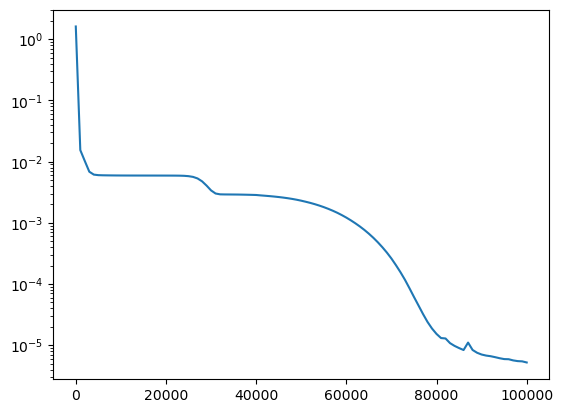

In [27]:
plt.plot(list(range(0, 100001,1000)), train_loss)
plt.yscale("log")
plt.show()

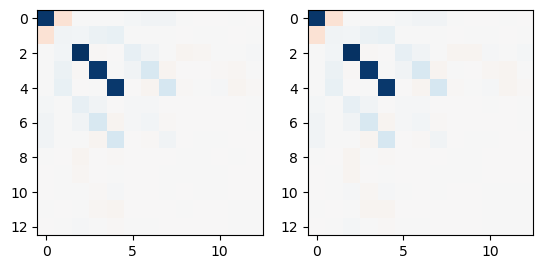

pao_ml_equivar/2H2O_rotations/rand_07/2H2O_pao44-1_0.pao: 7.141072e-04


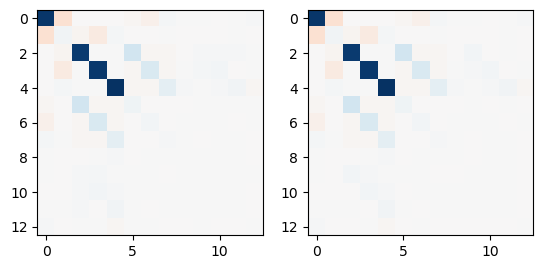

pao_ml_equivar/2H2O_rotations/rand_07/2H2O_pao44-1_0.pao: 1.019183e-03


In [28]:
batch_size = 1
path = Path("2H2O_rotations/rand_07/2H2O_pao44-1_0.pao")
test_pao_objects = generate_pao_object_from_file(path)
test_pao_objects_O = [pao_object for pao_object in test_pao_objects if pao_object.kind.atomic_number==8]
test_dataset_O = PAO_dataset(pao_objects_O)
#test_loader_O = DataLoader(test_dataset_O, batch_size=1, shuffle=False)

for pao_object in test_dataset_O:
    fig, axs = plt.subplots(nrows=1, ncols=2)
    edge_vecs, atomkinds, label = pao_object
    pred = model_O(edge_vecs.unsqueeze(0), atomkinds)
    label_projector = label.T @ label
    pred_projector = pred.squeeze().T @ pred.squeeze()
    #residual = torch.transpose(pred, dim0=1, dim1=2) - torch.bmm(label, torch.transpose(pred, dim0=1, dim1=2))
    axs[0].imshow(pred_projector.detach(), cmap="RdBu",vmin=-1, vmax=1)
    axs[1].imshow(label_projector.detach(), cmap="RdBu",vmin=-1, vmax=1)
    #plt.imshow((label_projector @ pred.squeeze().T).T.detach(), cmap="RdBu")
    #axs[0].imshow(pred.squeeze().detach(), cmap="RdBu", vmin=-1, vmax=1)
    #axs[1].imshow(pao_objects_O[i].label.detach(), cmap="RdBu", vmin=-1, vmax=1)
    plt.show()
    #plt.colorbar()
    #plt.show()
    test_mae = (label_projector-pred_projector).abs().mean()
    print(f"{path}: {test_mae:e}")

In [29]:
batch_size = 4
dataset_H = PAO_dataset(pao_objects_H)
training_loader_H = DataLoader(dataset_H, batch_size=batch_size, shuffle=False)
tp_H = o3.FullyConnectedTensorProduct(irreps_input, irreps_sh, generate_irreps_output(4, "H"), shared_weights=False)
num_distances = 10
num_layers = 32
fc_H = FullyConnectedNet([num_distances, num_layers, tp_H.weight_numel], torch.relu)
print("Hydrogen, Number of parameters: ", sum(p.numel() for p in fc_H.parameters()))

Hydrogen, Number of parameters:  1088


In [33]:
prim_basis_size = o3.Irreps(prim_basis_specs["H"]).dim
prim_basis_spec = prim_basis_specs["H"]
irreps_output = generate_irreps_output(pao_basis_size, "H")
D_H = irreps_output.D_from_matrix(change_of_coord)
#plt.imshow(D_H, cmap="RdBu", vmin=-1, vmax=1)
#plt.colorbar()

In [34]:
def model_H(edge_vec, f_in):
    sh = o3.spherical_harmonics(irreps_sh, edge_vec, normalize=True, normalization='component')
    emb = soft_one_hot_linspace(edge_vec.norm(dim=2), 0.0, max_radius, num_distances,
                                basis='smooth_finite', cutoff=True).mul(num_distances**0.5)
    flat_xyz = tp_H(f_in, sh, fc_H(emb)).sum(dim=1).div(num_neighbours**0.5)
    flat_yzx = torch.matmul(flat_xyz, D_H)
    return flat_xyz.reshape(batch_size, pao_basis_size, prim_basis_size)

In [35]:
# Train the model.
#M_H = Network(generate_irreps_output(4, "H"))
optim = torch.optim.Adam(fc_H.parameters(), lr=1e-3)
train_loss_H = []

#for step in range(20001):
#    edge_vecs, atomkinds, label = next(iter(training_loader_H))
#    pred = model_H(edge_vecs, atomkinds)
#    loss = loss_function_1(pred, label)
#    optim.zero_grad()
#    loss.backward()
#    optim.step()
#    if step % 1000 == 0:
#        print(f"warm up  {step:5d} | loss {loss:.8e}")

for step in range(100001): 
    edge_vecs, atomkinds, label = next(iter(training_loader_H))
    pred = model_H(edge_vecs, atomkinds)
    #pred = M_H(edge_vecs, atomkinds)
    loss = loss_function_2(pred, label)
    optim.zero_grad()
    loss.backward()
    optim.step()
    if step % 1000 == 0:
        train_loss_H.append(loss.detach())
        print(f"training {step:5d} | loss {loss:.8e}")

training     0 | loss 1.23426890e+00
training  1000 | loss 4.05116118e-02
training  2000 | loss 3.47156413e-02
training  3000 | loss 3.37243639e-02
training  4000 | loss 3.33006606e-02
training  5000 | loss 3.29496972e-02
training  6000 | loss 3.24275196e-02
training  7000 | loss 3.16255316e-02
training  8000 | loss 3.08308341e-02
training  9000 | loss 2.99351569e-02
training 10000 | loss 2.88566835e-02
training 11000 | loss 2.73592360e-02
training 12000 | loss 2.52161715e-02
training 13000 | loss 2.29983497e-02
training 14000 | loss 2.17847917e-02
training 15000 | loss 2.13568732e-02
training 16000 | loss 2.11702157e-02
training 17000 | loss 2.10832637e-02
training 18000 | loss 2.10370496e-02
training 19000 | loss 2.10147593e-02
training 20000 | loss 2.10003350e-02
training 21000 | loss 2.09893342e-02
training 22000 | loss 2.09803674e-02
training 23000 | loss 2.09722426e-02
training 24000 | loss 2.09640022e-02
training 25000 | loss 2.09559612e-02
training 26000 | loss 2.09471099e-02
t

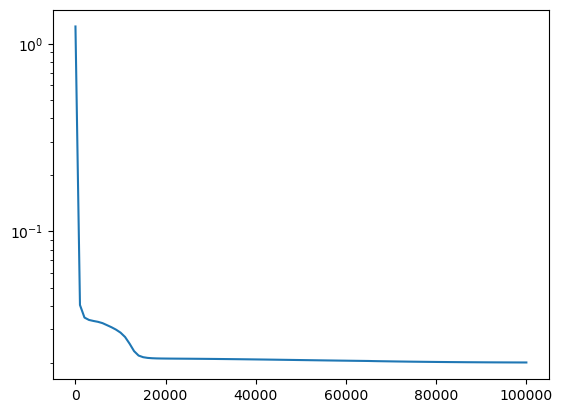

In [36]:
plt.plot(list(range(0, 100001,1000)), train_loss_H)
plt.yscale("log")
plt.show()

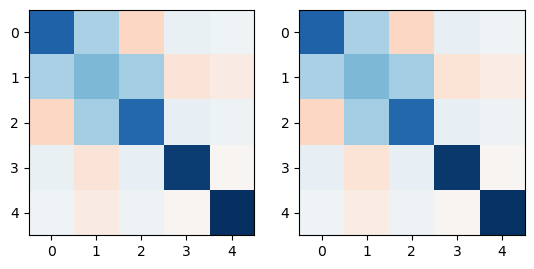

pao_ml_equivar/2H2O_rotations/phi_00/2H2O_pao44-1_0.pao: 2.065914e-03


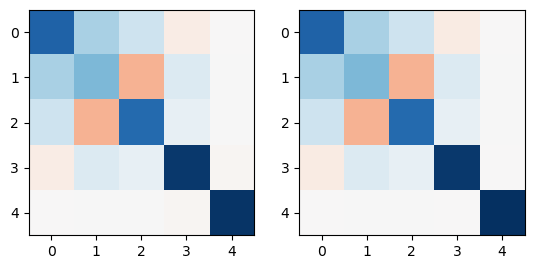

pao_ml_equivar/2H2O_rotations/phi_00/2H2O_pao44-1_0.pao: 3.579215e-03


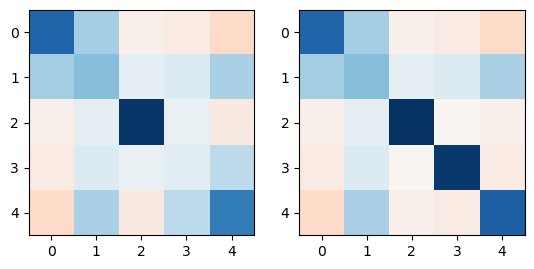

pao_ml_equivar/2H2O_rotations/phi_00/2H2O_pao44-1_0.pao: 7.835554e-02


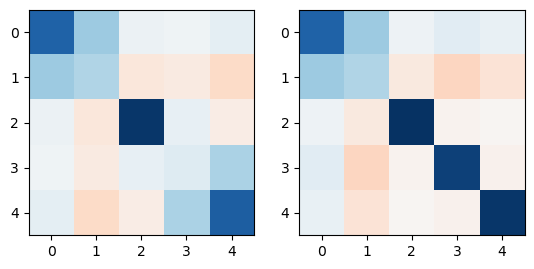

pao_ml_equivar/2H2O_rotations/phi_00/2H2O_pao44-1_0.pao: 1.044305e-01


In [37]:
batch_size=1
path = Path("2H2O_rotations/phi_00/2H2O_pao44-1_0.pao")
pao_objects = generate_pao_object_from_file(path)
pao_objects_H = [pao_object for pao_object in pao_objects if pao_object.kind.atomic_number==1]
dataset = PAO_dataset(pao_objects_H)
training_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

for pao_object in dataset:
    fig, axs = plt.subplots(nrows=1, ncols=2)
    edge_vecs, atomkinds, label = pao_object
    pred = model_H(edge_vecs.unsqueeze(0), atomkinds)
    label_projector = label.T @ label
    pred_projector = pred.squeeze().T @ pred.squeeze()

    axs[0].imshow(pred_projector.detach(), cmap="RdBu",vmin=-1, vmax=1)
    axs[1].imshow(label_projector.detach(), cmap="RdBu",vmin=-1, vmax=1)
    #axs[0].imshow(pred.squeeze().detach(), cmap="RdBu", vmin=-1, vmax=1)
    #axs[1].imshow(pao_object.xblock.detach(), cmap="RdBu", vmin=-1, vmax=1)
    plt.show()
    test_mae = (label_projector-pred_projector).abs().mean()
    print(f"{path}: {test_mae:e}")

In [38]:
batch_size=1
for path in sorted(Path().glob("2H2O_rotations/rand_*/2H2O_pao44-1_0.pao")):
    pao_objects = generate_pao_object_from_file(path)
    pao_objects_O = [pao_object for pao_object in pao_objects if pao_object.kind.atomic_number==8]
    pao_objects_H = [pao_object for pao_object in pao_objects if pao_object.kind.atomic_number==1]
    kinds, atom2kind, sample_coords, sample_xblocks = parse_pao_file_torch(path)
    pred_xblocks = sample_xblocks.copy()
    
    prim_basis_size = o3.Irreps(prim_basis_specs["O"]).dim    
    pred_xblocks[0] = model_O(pao_objects_O[0].coords.unsqueeze(dim=0), generate_f_in(pao_objects_O[0]).unsqueeze(dim=0)).squeeze()
    pred_xblocks[3] = model_O(pao_objects_O[1].coords.unsqueeze(dim=0), generate_f_in(pao_objects_O[1]).unsqueeze(dim=0)).squeeze()
    
    prim_basis_size = o3.Irreps(prim_basis_specs["H"]).dim
    pred_xblocks[1] = model_H(pao_objects_H[0].coords.unsqueeze(dim=0), generate_f_in(pao_objects_H[0]).unsqueeze(dim=0)).squeeze()
    pred_xblocks[2] = model_H(pao_objects_H[1].coords.unsqueeze(dim=0), generate_f_in(pao_objects_H[1]).unsqueeze(dim=0)).squeeze()
    pred_xblocks[4] = model_H(pao_objects_H[2].coords.unsqueeze(dim=0), generate_f_in(pao_objects_H[2]).unsqueeze(dim=0)).squeeze()
    pred_xblocks[5] = model_H(pao_objects_H[3].coords.unsqueeze(dim=0), generate_f_in(pao_objects_H[3]).unsqueeze(dim=0)).squeeze()
    
    write_pao_file(path.parent / "2H2O_pao44_eval.pao", kinds, atom2kind, sample_coords, pred_xblocks)
    ! cd {path.parent}; OMP_NUM_THREADS=8 /data/vdella/software/cp2k/exe/local/cp2k.sdbg 2H2O_pao44_eval.inp > 2H2O_pao44_eval.out
    test_energy = read_cp2k_energy(path.parent / "2H2O_pao44_eval.out")
    ref_energy = read_cp2k_energy(path.parent / "2H2O_pao44.out")
    rel_diff_energy = (test_energy - ref_energy) / ref_energy
    print(f"{path}: Relative Energy Diff: {rel_diff_energy:e}")
    ! grep "SCF run converged in" {path.parent}/2H2O_pao44_eval.out

pao_ml_equivar/2H2O_rotations/rand_00/2H2O_pao44-1_0.pao: Relative Energy Diff: -3.245910e-04
 SCF run converged in     9 steps.
pao_ml_equivar/2H2O_rotations/rand_01/2H2O_pao44-1_0.pao: Relative Energy Diff: -3.348057e-04
 SCF run converged in     9 steps.
pao_ml_equivar/2H2O_rotations/rand_02/2H2O_pao44-1_0.pao: Relative Energy Diff: -3.657424e-04
 SCF run converged in     9 steps.
pao_ml_equivar/2H2O_rotations/rand_03/2H2O_pao44-1_0.pao: Relative Energy Diff: -5.046782e-04
 SCF run converged in     9 steps.
pao_ml_equivar/2H2O_rotations/rand_04/2H2O_pao44-1_0.pao: Relative Energy Diff: -5.646279e-04
 SCF run converged in     9 steps.
pao_ml_equivar/2H2O_rotations/rand_05/2H2O_pao44-1_0.pao: Relative Energy Diff: -5.647302e-04
 SCF run converged in     9 steps.
pao_ml_equivar/2H2O_rotations/rand_06/2H2O_pao44-1_0.pao: Relative Energy Diff: -4.777157e-04
 SCF run converged in     9 steps.
pao_ml_equivar/2H2O_rotations/rand_07/2H2O_pao44-1_0.pao: Relative Energy Diff: -4.405068e-04
 SC

In [589]:
# Classes to build own neural network, potentially with more convolutional layers
class Convolution(torch.nn.Module):
    def __init__(self, irreps_in, irreps_sh, irreps_out, num_neighbors) -> None:
        super().__init__()

        self.num_neighbors = num_neighbors

        tp = FullyConnectedTensorProduct(
            irreps_in1=irreps_in,
            irreps_in2=irreps_sh,
            irreps_out=irreps_out,
            internal_weights=False,
            shared_weights=False,
        )
        self.fc = FullyConnectedNet([10, 64, tp.weight_numel], torch.relu)
        self.tp = tp
        self.irreps_out = self.tp.irreps_out

    def forward(self, f_in, sh, emb) -> torch.Tensor:
        weight = self.fc(emb)
        output = self.tp(f_in, sh, weight).div(self.num_neighbors**0.5)
        return output


class Network(torch.nn.Module):
    def __init__(self, irreps_output) -> None:
        super().__init__()
        self.num_neighbors = 5  # typical number of neighbors
        self.irreps_sh = o3.Irreps.spherical_harmonics(3)
        self.irreps_out = irreps_output

        irreps = self.irreps_sh

        # First layer with gate
        gate = Gate(
            "16x0e + 16x0o", [torch.relu, torch.abs],  # scalar
            "8x0e + 8x0o + 8x0e + 8x0o", [torch.relu, torch.tanh, torch.relu, torch.tanh],  # gates (scalars)
            "16x1o + 16x1e"  # gated tensors, num_irreps has to match with gates
        )
        self.conv = Convolution(irreps_input, self.irreps_sh, gate.irreps_in, self.num_neighbors)
        self.gate = gate
        irreps = self.gate.irreps_out

        # Final layer
        self.final = Convolution(self.gate.irreps_out, self.irreps_sh, generate_irreps_output(4, "H"), self.num_neighbors)
        self.irreps_out = self.final.irreps_out

    def forward(self, edge_vecs, atomkinds) -> torch.Tensor:
        num_nodes = 5  # typical number of nodes

        edge_attr = o3.spherical_harmonics(
            l=self.irreps_sh,
            x=edge_vecs,
            normalize=True,
            normalization='component'
        )
        edge_length_embedded = soft_one_hot_linspace(
            x=edge_vecs.norm(dim=2),
            start=0.0,
            end=4.0,
            number=10,
            basis='smooth_finite',
            cutoff=True
        ) * 10**0.5

        x = self.conv(atomkinds, edge_attr, edge_length_embedded)
        x = self.gate(x)
        x = torch.sum(self.final(x, edge_attr, edge_length_embedded), dim=1)
        x = torch.matmul(x, D_H)

        return x.reshape(batch_size, pao_basis_size, prim_basis_size)